In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df =  df.set_index(['Month'])

In [26]:
df['Seasonal_1month_Difference']=df['Passengers']-df['Passengers'].shift(1)

In [27]:
df.head()

,Passengers,Seasonal_2month_Difference,Seasonal_1month_Difference
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,6.0
1949-03-01,132,20.0,14.0
1949-04-01,129,11.0,-3.0
1949-05-01,121,-11.0,-8.0


<AxesSubplot:xlabel='Month'>

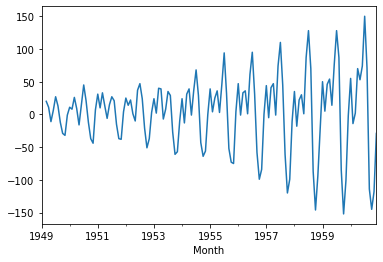

In [6]:
df['Seasonal_2month_Difference'].plot()

In [7]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [8]:
adfuller_test(df['Seasonal_2month_Difference'][2:])

ADF Test Statistic : -2.9616951355554337
p-value : 0.03862975767698741
#Lags Used : 11
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


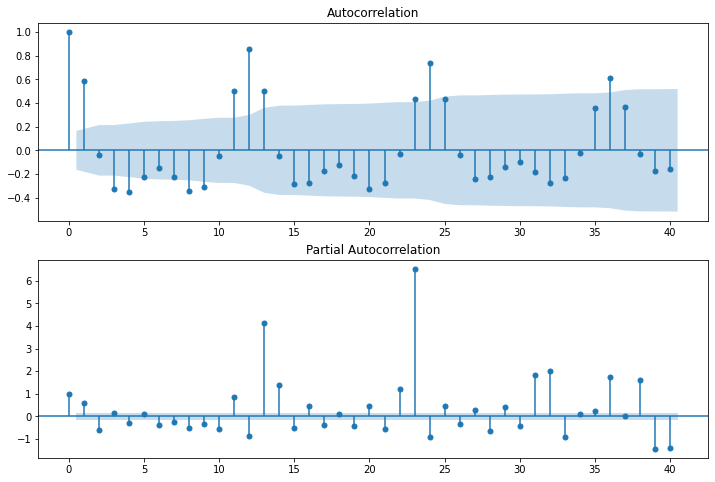

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal_2month_Difference'].iloc[2:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal_2month_Difference'].iloc[2:],lags=40,ax=ax2)

# SARIMAX

### how to choose --- P,D,Q,S
## Now, instead of count how many lollipops are out of the confidence interval, you will count how many seasonal lollipops are out.
### P=2 , D=0 , Q=3 , S =12
### p =2, d=2 , q=1

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

def SARIMA_function(data,p,d,q,P, D, Q, S,predict_m):
    a  = df.shape[0]
    train_data = data[0:a-predict_m]
    test_data =data[a-predict_m:]
    model1 = SARIMAX(train_data, order=(p,d,q),seasonal_order=(P, D, Q, S))
    model_fit1 = model1.fit()
    # make prediction
    predictions = model_fit1.predict(start=len(train_data),end=len(train_data)+len(test_data)-1)
    compare_df = pd.concat(
        [data.tail(predict_m),
        predictions.apply(np.floor)], axis=1).rename(
        columns={'Passengers': 'actual', 0:'predicted'})
    compare_df.plot()
    r2 = r2_score(data.tail(predict_m), predictions.apply(np.floor))
    print("r2_score:{} ,AIC:{},BIC:{}".format(r2 , model_fit1.aic,model_fit1.bic))
    return r2

r2_score:0.9502353378685489 ,AIC:1089.2481068608565,BIC:1115.462000832481


0.9502353378685489

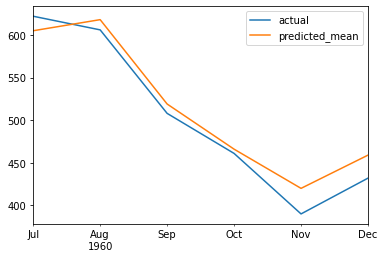

In [23]:
SARIMA_function(df['Passengers'],2,2,1,2,0,3,12,6)

r2_score:0.950167722838479 ,AIC:1087.1049653096368,BIC:1110.4062043955253


0.950167722838479

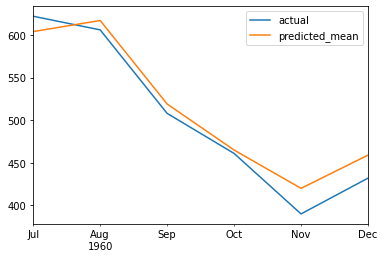

In [24]:
SARIMA_function(df['Passengers'],2,2,1,2,0,2,12,6)

<AxesSubplot:xlabel='Month'>

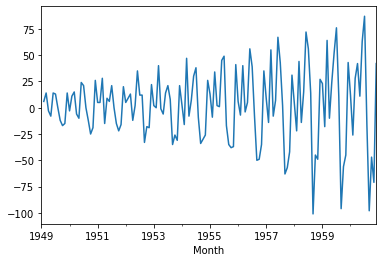

In [28]:
df['Seasonal_1month_Difference'].plot()

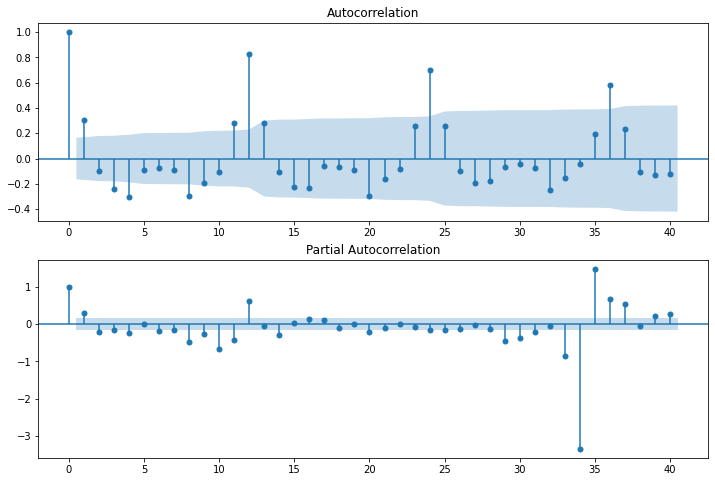

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal_1month_Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal_1month_Difference'].iloc[2:],lags=40,ax=ax2)

### p =1,2,3, d=1 ,q =1
### P= 1, D=0,1, Q= 3 ,S=12

r2_score:0.9378392490223993 ,AIC:1093.919938113419,BIC:1114.3598045942158


0.9378392490223993

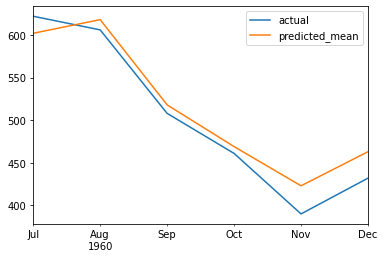

In [30]:
SARIMA_function(df['Passengers'],1,1,1,1,0,3,12,6)

r2_score:0.9724581444181915 ,AIC:1091.0732958371127,BIC:1114.4331432437377


0.9724581444181915

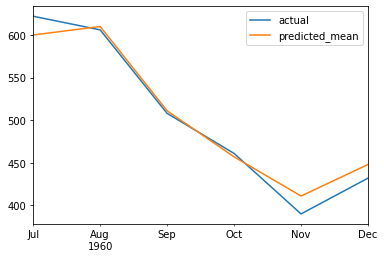

In [31]:
SARIMA_function(df['Passengers'],2,1,1,1,0,3,12,6)

r2_score:0.9743964419468621 ,AIC:1091.0054105485945,BIC:1117.2852388810477


0.9743964419468621

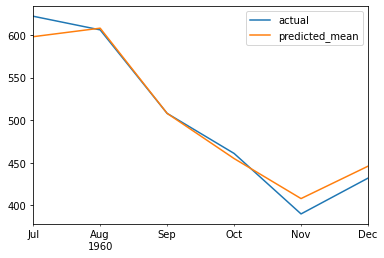

In [34]:
SARIMA_function(df['Passengers'],3,1,1,1,0,3,12,6)

r2_score:0.9782279603174902 ,AIC:972.0749608813961,BIC:997.5297845171168


0.9782279603174902

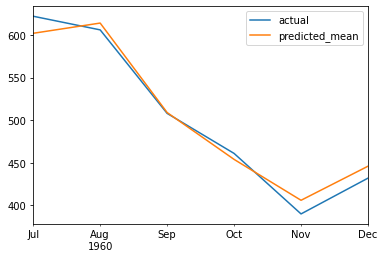

In [42]:
SARIMA_function(df['Passengers'],3,1,1,1,1,3,12,6)

r2_score:0.9761995094153929 ,AIC:970.928598566817,BIC:993.5551084652353


0.9761995094153929

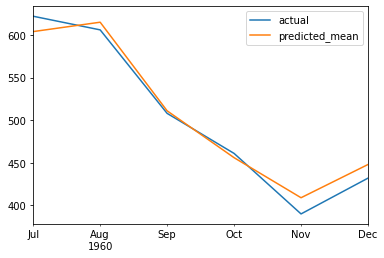

In [44]:
SARIMA_function(df['Passengers'],2,1,1,1,1,3,12,6)

## https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html